In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import transformerblock as tran
import GCN
import os
import matplotlib.pyplot as plot

Sembla que els .h m'estan donant massa problemes, si els csv surten bé i es poden importar correctament seria l'hostia


In [3]:
# dades = pd.read_hdf('datasets/metr-la.h5')
# freq = 0
# dset = dades['773869']


second = pd.read_csv('datasets/PEMS-BAY.csv')
dset2 = second['400001']

In [4]:
matrix = pd.read_pickle('datasets/adj_mx_PEMS-BAY.pkl')
adj_matrx = matrix

"""
def load_graph_data(pkl_filename):
    sensor_ids, sensor_id_to_ind, adj_mx = load_pickle(pkl_filename)
    return sensor_ids, sensor_id_to_ind, adj_mx
"""

adj_mtx = sp.coo_matrix(adj_matrx[2])
# grafo = nx.Graph(adj_mtx)


En els papers diuen que utilitzen un model per fer la espacial que es basa en facer una regularització laplaciana en les funcions de perdues

segons el paper: L = L0 + sigmaLreg

 Lreg =sumatori i,j Aij ||f(Xi) − f(Xj )^2|| = f(X)^T ∆f(X).

L0 es la perdua supervisada

El Xout de la espacial ha de ser
Xout = σ(D˜ ^-1/2 A˜ D˜ ^−1/2 Xin W) 
la sigma aes una ReLU(·)

A~ = A + In on  a es la matriu d'adjecencia i l'altre la identitat

In [5]:
####Normalitzar adjecencia, funcion treta d'un paper

def degree_mat(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)) # aqui seria d'on sortirien els valors de la diagonal 
    # d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    # d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    # d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    # return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    return rowsum


In [6]:
def ref_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)) # aqui seria d'on sortirien els valors de la diagonal 
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

In [7]:
def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

In [8]:
def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return sparse_to_tuple(features)

Per definir el graf del sistema ho farem de la seguent manera

Vertex hidden value -> Valor Q dels sensors Edge value -> VAlor de l'adjecencia de la matriu R

Funcions del message passing: Update -> suma del valor anterior Agregació -> convolució del graf W -> el valor de la funció Xout

x' = Wx'i + W Sumatori(xj / sqrt(di*dj)) per j pertanyent a N(i)U(i)

In [9]:
adj_mtx_csr = adj_mtx.tocsr()
adj_csr_rdx = adj_mtx_csr[00:10,00:10]
D = degree_mat(adj_csr_rdx) # matriu que ens mostra el nivell de conexió del sensor
A = ref_adj(adj_csr_rdx) # matriu d'adjacencies ajustada i refinada
A_tp = sparse_to_tuple(A)
Ds = sp.csr_matrix(D)
D_tp = sparse_to_tuple(Ds)
#com que es la pemsbay es el dataset second
hidden_value_all= second #matriu en forma de fila 0 index nom dels sensors i cap avall en les columnes el valor q de cada sensor cada 5 minuts

#####seria una bona idea treballar amb 10 sensors per ara, k es més visual

hidden_value = hidden_value_all.iloc[:1, 1:11]

hidden_A  = hidden_value.to_numpy()
hidden_valuem = sp.csr_matrix(hidden_value)
hidden_value = preprocess_features(hidden_valuem)

#en la primera instancia del temps els valors q de tots els sensors
# Hs = sp.csr_matrix(hidden_value)
# H_tp = sparse_to_tuple(Hs)
# graph = nx.from_scipy_sparse_matrix(A.tocsc())
# print(nx.edges(graph))

In [10]:
def gen_tensors(mtx):
    idx, idy, val = sp.find(mtx)
    full_indices = tf.stack([idx, idy], axis=1)
    tamany = mtx.shape
    full_indices=tf.cast(full_indices,dtype=tf.int64)
    sparse = tf.sparse.SparseTensor(full_indices,val,tamany)
    sparse=tf.sparse.reorder(sparse)
    # dense = tf.sparse.to_dense(sparse)
    return(sparse)

In [11]:
def message_passing(A,D,hidden):
    A64 = tf.cast(A,dtype=tf.float64)
    A_Hidd = tf.stack([A64,hidden])
    D_layyer = layers.Dense()
    output = D_layyer(A_Hidd)

    #aggregation of messages
    aggr = tf.math.segment_sum(output,D)
    return(aggr)


In [12]:
def one_hop(F, A):
    Fp =[]
    for i in range(A[0].size):
        aux = F[i]*A[i][0]
        Fp.append(np.sum(aux))
    return(Fp)

A_d = A.todense()
passe1 = one_hop(hidden_A[0],A_d)
one_hop(passe1,A_d)

[71.4, 67.8, 125.39743, 67.4, 54.39285, 66.6, 43.50115, 68.0, 66.8, 69.0]

In [13]:
def Mask_A(mat):
    A_mask = mat
    for i in range(mat.shape[0]):
        for j in range(mat[i].size):
            if mat[i,j]> 0:
                A_mask[i,j]=1
    return(A_mask)


In [14]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []
    fnn_layers.append(layers.BatchNormalization())

    for units in hidden_units:
        fnn_layers.append(layers.Dense(units, activation=tf.nn.relu))
        fnn_layers.append(layers.Dropout(dropout_rate))
        
    fnn_layers.append(layers.Dense(units, activation=tf.nn.relu))
    return keras.Sequential(fnn_layers, name=name)

In [15]:
gcn = GCN.GraphConvLayer([1],aggregation_type="sum")

#quan crido la gcn els inputs ahn d'estar en una sola entrada de manera
# node_features les features de cada node [num_nodes, num_features]
# edges matriu adjacencia enmascarada per que siguin 1 i 0 i es marqui adjacencia pura, ha de ser sparse matrix
# la aquesta ha de ser shape [2, num_edges]
# edge wheights nunmpy array amb els pesos del edges [num_edges]
A_mask = Mask_A(A.tocsr().toarray()) #aquesta funcio enmascara la adjecencia normalizada en si o no, el pesos estan guardats en altres matrius
A_mask = sp.csr_matrix(A_mask)
keys_a =[]

for i in range(A_mask.toarray()[0].size):
    for j in range(A_mask[i].size):
        keys_a.append(i)
a_keys = A_mask.indices
keys_a = np.array(keys_a)
edges = np.array([a_keys,keys_a])

hidden_B = tf.cast(hidden_A,dtype=tf.float32)
hidden_C = tf.reshape(hidden_B, [10,1])
a_p = A.tocsr()

ffn1 = create_ffn([1], 0.2, name="preprocess")
node_representations = ffn1(hidden_C)

out = gcn((node_representations, edges, a_p.data))

node_rep = out + node_representations

out2 = gcn((node_rep, edges, a_p.data))

node_rep2 = out2 + node_rep
outs = ffn1(node_rep2)

emmbeddings = tf.gather(outs,edges[0])

In [16]:
class convolutions_passing(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        hidden_units,
        aggregation_type="sum",
        combination_type="gru",
        dropout_rate=0.2,
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        edges, edge_weights = graph_info
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GCN.GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GCN.GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        # self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_features):
        # Preprocess the node_features to produce node representation
        x = self.preprocess(input_node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        #node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return x


In [17]:
#ja tenim el model construit, ara es qüestió de entrenar-lo i mirar de que estigui apunt
hidden_value = hidden_value_all.iloc[:1, 1:]
hidden_D  = hidden_value.to_numpy()
hidden_E = tf.cast(hidden_D,dtype=tf.float32)
hidden_F = tf.reshape(hidden_E, [hidden_D.size,1])
node_rep=ffn1(hidden_F)

adj_mtx_csr = adj_mtx.tocsr()
A = ref_adj(adj_mtx_csr)

A_mask = Mask_A(A.tocsr().toarray()) #aquesta funcio enmascara la adjecencia normalizada en si o no, el pesos estan guardats en altres matrius
A_mask = sp.csr_matrix(A_mask)
keys_a =[]
for i in range(A_mask.toarray()[0].size):
    for j in range(A_mask[i].size):
        keys_a.append(i)
a_keys = A_mask.indices
keys_a = np.array(keys_a)
edges = np.array([a_keys,keys_a])
preprocess = create_ffn([1], 0.2, name="preprocess")
a_p = A.tocsr()
model_F = convolutions_passing(    
    graph_info=(edges, a_p.data),
    hidden_units=[1],
    dropout_rate=0.2,
    name="gnn_model_full")

In [18]:
hidden_value_next = hidden_value_all.iloc[1:2, 1:]
hidden_D_next  = hidden_value_next.to_numpy()
hidden_E_next = tf.cast(hidden_D_next,dtype=tf.float32)
hidden_F_next = tf.reshape(hidden_E_next, [hidden_D_next.size,1])


model_F.compile(optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=[keras.metrics.MeanAbsoluteError(name="mae"),keras.metrics.MeanAbsolutePercentageError(name="mape"),keras.metrics.RootMeanSquaredError(name="rmse")])
model_F.build([325,1])

manera de fer que tot estigui com hauria d'estar, s'ha de fer un reshape general del dataset segur 

donatt que el dataset original es segur [x,325] on x son els timesteps que tenim, es podrien tindre de manera senzilla amb una eina de tall o demanant el size [,1].size

fent la transposició ho fa tot molt més facil per operar, la matriu d'adjacencia s'hauria de modificar per si aca, crec


In [19]:
hidden_value_sans_names = hidden_value_all.iloc[:, 1:]

hidden_D_sans  = hidden_value_sans_names.to_numpy()
hidden_E_sans = tf.cast(hidden_D_sans,dtype=tf.float32)

shapes = hidden_E_sans.shape

noves_shapes = tf.reshape(hidden_E_sans, [shapes[1],shapes[0]])


In [20]:
def predictor_layer(name="Predictor"):
    predictor_layers =[]
    predictor_layers.append(keras.layers.Dense(64,activation='relu'))
    predictor_layers.append(keras.layers.Dense(32,activation='relu'))
    predictor_layers.append(keras.layers.Dense(1))

    return keras.Sequential(predictor_layers, name=name)

In [187]:
class STGNN(tf.keras.Model):
    def __init__(
        self,
        graph_info, #matriu d'adjecencia del graph
        hidden_units, #quantes features estarem tractant per timestep i sensor
        aggregation_type="sum",
        combination_type="gru",
        dropout_rate=0.2,
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        edges, edge_weights = graph_info
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize
        self.hidden_units = hidden_units


        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GCN.GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create a postprocess layer.
        # self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        # self.compute_logits = layers.Dense(units=num_classes, name="logits")

        self.grucell = tf.keras.layers.GRUCell(64,name="Gru_temporal")

        # self.NovaGRU = tf.keras.layers.GRU(64,name="Gru_final")
        
        self.tbloc = tran.TransformerBlock(
            embed_dim=64, 
            num_heads=4, 
            ff_dim=64
        )

        self.pool = keras.layers.GlobalAveragePooling1D()
        
        self.predictor = predictor_layer()
        # la prediction layer es una multi feed-forward network per predir veloocitat transit

    
    

    def call(self, input_node_features_all):
        old_x = input_node_features_all[0] #[325]
        old_x = tf.expand_dims(old_x,axis=1)
        old_x = self.preprocess(old_x)
        
        x_full= tf.expand_dims(old_x,axis=1)

        for input_node_features in input_node_features_all[1:] :

            tf.autograph.experimental.set_loop_options(
            shape_invariants=[(x_full, tf.TensorShape([x_full.shape[0],None,x_full.shape[2]]))]
            )

            # Preprocess the node_features to produce node representation
            # x = tf.reshape(input_node_features_all,[input_node_features_all.shape[1],input_node_features_all.shape[0]])
            x =tf.expand_dims(input_node_features,axis = 1)
            x = self.preprocess(x)
            # Apply the first graph conv layer.
            # treure els edges i els pesos prk siguin mobils
            # call (self, input_dictionary)
            x1 = self.conv1((x, self.edges, self.edge_weights))
            # Skip connection.
            x = x1 + x
            # Apply the second graph conv layer.
            # Postprocess node embedding.
            x, x2 = self.grucell(x,old_x) 
            old_x = x2
            x_full = tf.concat([x_full,tf.expand_dims(old_x,axis=1)],1)
        

        
        x_full = tf.convert_to_tensor(x_full,tf.float32)
        # sortiran bastant més valors del transformer, es pot provar amb i o sense transformer 
        res = self.tbloc(x_full,x_full) #hauria de treure 325, 12, 64
        res = self.pool(res) #[325,64]
        x = self.predictor(res) # hauria de treure 325, 12, 1 SEWMPRE una sortida
        # return tf.squeeze(tf.transpose(x)) #es treu el valor amb forma (325,) que es equivalent a [325,1] amb feina extra
        return x


In [188]:
model_Full = STGNN(    
    graph_info=(edges, a_p.data),
    hidden_units=[64],
    dropout_rate=0.2,
    name="Spatio_temporal_model")

In [189]:
hidden_M_sans  = hidden_value_sans_names.iloc[:5,:]

alll = tf.cast(hidden_value_sans_names,dtype=tf.float32)

mitja_Set = tf.cast(hidden_M_sans,dtype=tf.float32)

next_M_sans  = hidden_value_sans_names.iloc[5:10,:]



nexting_set = tf.cast(next_M_sans,dtype=tf.float32)

mitja_SET = tf.reshape(mitja_Set,[mitja_Set.shape[1],mitja_Set.shape[0]])
nexting_SET = tf.reshape(nexting_set,[nexting_set.shape[1],nexting_set.shape[0]])


model_Full(mitja_Set) #enviar en troços petits

<tf.Tensor: shape=(325, 1), dtype=float32, numpy=
array([[-0.1516121 ],
       [-0.14943326],
       [-0.1511929 ],
       [-0.14864224],
       [-0.15003586],
       [-0.14825356],
       [-0.14854848],
       [-0.14963406],
       [-0.14871871],
       [-0.1508615 ],
       [-0.14960253],
       [-0.14931542],
       [-0.14932323],
       [-0.14956224],
       [-0.14900607],
       [-0.14984429],
       [-0.1494906 ],
       [-0.14984423],
       [-0.15025002],
       [-0.14928395],
       [-0.14922827],
       [-0.14932662],
       [-0.14986151],
       [-0.14853042],
       [-0.14991117],
       [-0.15041482],
       [-0.15028828],
       [-0.14926273],
       [-0.14800006],
       [-0.14921087],
       [-0.14824432],
       [-0.15063691],
       [-0.15045148],
       [-0.15082741],
       [-0.14972574],
       [-0.14930218],
       [-0.15262955],
       [-0.14975989],
       [-0.15071183],
       [-0.15082389],
       [-0.14999026],
       [-0.14949685],
       [-0.14913303],
    

In [190]:
print(alll[12:13].shape)

(1, 325)


In [24]:
# model_Full.build(input_shape=[5,325])
print(model_Full.summary())

Model: "Spatio_temporal_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Sequential)      (325, 64)                 4292      
_________________________________________________________________
graph_conv1 (GraphConvLayer) multiple                  8832      
_________________________________________________________________
Gru_temporal (GRUCell)       multiple                  24960     
_________________________________________________________________
Gru_final (GRU)              multiple                  24960     
_________________________________________________________________
transformer_block (Transform multiple                  74944     
_________________________________________________________________
Predictor (Sequential)       (325, 1)                  6273      
Total params: 144,261
Trainable params: 144,003
Non-trainable params: 258
_____________________________________

In [25]:
x=[]
y=[]

for i in range(0,len(alll)-6,5):
    x.append(alll[i:i+5])
    y.append(alll[i+6])


In [26]:
x_dim = np.expand_dims(x,axis=1)
y_dim = np.expand_dims(y,axis=1)

In [27]:
def generator(data):
    x=[]
    y=[]

    for i in range(0,len(alll)-6,5):
        x.append(alll[i:i+5])
        y.append(alll[i+6])

    y_dim = np.expand_dims(y,axis=1)

    yield x, y_dim

In [28]:
#funcio per generar el dataset de tf
ds = tf.data.Dataset.from_generator(
    generator,
    args=[alll],
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
)
print(ds)

<FlatMapDataset shapes: ((), ()), types: (tf.float32, tf.float32)>


In [29]:

alll_t  = tf.transpose(alll)

win_size=12

x_train = []
y_train = []

for i in range(win_size, alll.shape[0]-win_size):
    x_train.append(alll[i-win_size:i, :])
    y_train.append(alll[i:win_size+i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

(52092, 12, 325)


In [30]:
# Prepare the test data
x_test = []
y_test = []

for i in range(win_size, alll.shape[0]-win_size):
    x_test.append(alll[i-win_size:i, :])
    y_test.append(alll[i:win_size+i, :])

x_test, y_test = np.array(x_test), np.array(y_test)
print(y_test.shape)

(52092, 12, 325)


In [93]:
data = tf.keras.utils.timeseries_dataset_from_array(alll,alll[12:],12) #aquesta ha estat la que ha funcionat
for batch in data:
  inputs, targets = batch
  print(targets[0].shape)
  print(inputs[0].shape)
  assert np.array_equal(inputs[0], alll[:12])  # First sequence: steps [0-9]
  # Corresponding target: step 10
  assert np.array_equal(targets[0], alll[12])
  break

data=data.unbatch()

(325,)
(12, 325)


In [32]:
%load_ext tensorboard

In [135]:
data = data.repeat(5)


train=data.take(200000)
test=data.skip(200000)

es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=30, restore_best_weights=True)

tensorboard =  tf.keras.callbacks.TensorBoard(log_dir="logs")



model_Full.compile(optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae"),tf.keras.metrics.MeanAbsolutePercentageError(name="mape"),tf.keras.metrics.RootMeanSquaredError(name="rmse")])
# modelckpt_callback = keras.callbacks.ModelCheckpoint(monitor="val_loss",filepath="sub_wheights_"+str(rate)+".hdf5",verbose=1,save_weights_only=True,save_best_only=True)
filepath = os.path.join("pesos_final_v2", "{epoch:02d}-{val_loss:.4f}")
modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=filepath,
verbose=1,
mode="min",
monitor='val_loss',
save_best_only=False,
save_weights_only=True,
save_freq='epoch')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5,
                                                patience=10, verbose=1)

model_Full.fit(
    x=train,
    epochs = 20,
    batch_size=1, 
    steps_per_epoch=5000,
    validation_data=test,
    validation_steps=2000,
    use_multiprocessing=True,
    callbacks =[es_callback,modelckpt_callback,tensorboard,reduce_lr]
    )

# s'haura de fer un expand dims 1 i transposar a les sortides del model

Epoch 1/20
5000/5000 [==============================] - 617s 123ms/step - loss: 1.9609 - mae: 1.9609 - mape: 3.8821 - rmse: 6.2716 - val_loss: 2.2482 - val_mae: 2.2482 - val_mape: 4.2129 - val_rmse: 2.9345

Epoch 00001: saving model to pesos_final_v2\01-2.2482
Epoch 2/20
5000/5000 [==============================] - 612s 122ms/step - loss: 1.6355 - mae: 1.6355 - mape: 3.7763 - rmse: 3.1516 - val_loss: 3.9995 - val_mae: 3.9995 - val_mape: 8.0970 - val_rmse: 4.7391

Epoch 00002: saving model to pesos_final_v2\02-3.9995
Epoch 3/20
5000/5000 [==============================] - 539s 108ms/step - loss: 1.4741 - mae: 1.4741 - mape: 3.2206 - rmse: 2.8024 - val_loss: 4.2582 - val_mae: 4.2582 - val_mape: 9.5102 - val_rmse: 5.8922

Epoch 00003: saving model to pesos_final_v2\03-4.2582
Epoch 4/20
5000/5000 [==============================] - 481s 96ms/step - loss: 1.5369 - mae: 1.5369 - mape: 3.2792 - rmse: 2.7441 - val_loss: 2.7046 - val_mae: 2.7046 - val_mape: 5.9088 - val_rmse: 3.9653

Epoch 00004

In [ ]:
model_Full.save_weights("./pesos_bastant_entrenats")

In [211]:
model_Full.load_weights("pesos_final_v2/10-1.1681")

In [163]:
print(model_Full.predict(alll[:12]).shape)


cpmar = np.concatenate([np.expand_dims(alll[starting_point+12],axis=1),
model_Full.predict(alll[starting_point:starting_point+12])],
axis=1)
print(cpmar.shape)

plot.title("1 timestep tots els sensors")
plot.plot(cpmar[50:200],label=["real","pred"]) #Per un moment concret es el que tenim
plot.legend()
plot.xlabel("Nº sensors 50-200")
plot.ylabel("Q metric")
plot.grid()
plot.rcParams["figure.figsize"]=(11,3)
plot.show()
# plot de coses com aquestes, queda maco

(325,)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

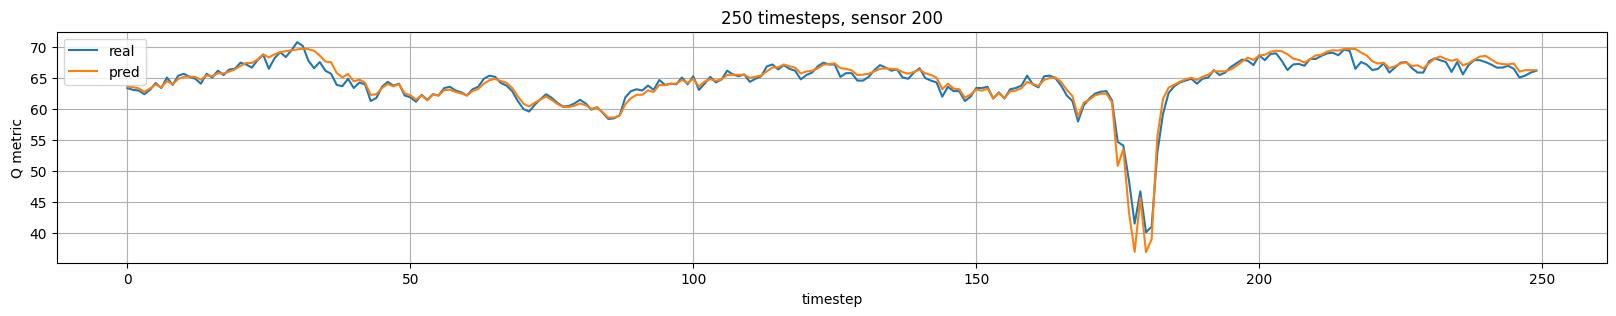

In [213]:
valors_sueltos = []
starting_point = 15000
for x in range(250):

    cpmar = np.concatenate([np.expand_dims(alll[x+starting_point+11],axis=1),
    model_Full.predict(alll[starting_point+x:starting_point+x+12])],axis=1)
    valors_sueltos.append(cpmar[200])

plot.title("250 timesteps, sensor 200")
plot.plot(valors_sueltos,label=["real","pred"]) #Per un moment concret es el que tenim
plot.legend()
plot.xlabel("timestep")
plot.ylabel("Q metric")
plot.grid()
plot.rcParams["figure.figsize"]=(20,3)
plot.show()

In [52]:
starting_point = 42116
iteracions = 100//24
desv =0
outputs=[]
grand_acum =[]
for x in range(iteracions):

    inputs = alll[desv+starting_point:desv+starting_point+12]
    for i in range(len(inputs)):
        res = model_Full.predict(inputs)
        a, inputs=tf.split(inputs,[1,11],0)
        outputs.append(res)
        inputs = tf.concat([inputs,tf.transpose(res)],0)
    grand_acum.append(outputs)
    desv+=12

In [218]:
res = model_Full.predict(alll[12:24])
print(res.shape)
res = tf.transpose(res)
print(res.shape)

(325, 1)
(1, 325)


(325, 2)


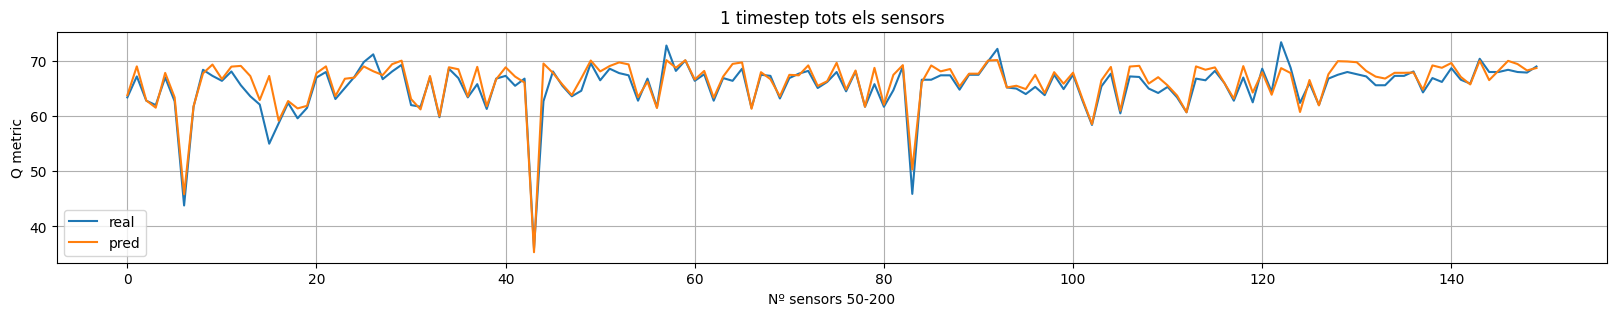

In [224]:
cpmar = np.concatenate([np.expand_dims(alll[15000],axis=1),
outputs[0]],
axis=1)
print(cpmar.shape)

plot.title("1 timestep tots els sensors")
plot.plot(cpmar[50:200],label=["real","pred"]) #Per un moment concret es el que tenim
plot.legend()
plot.xlabel("Nº sensors 50-200")
plot.ylabel("Q metric")
plot.grid()
plot.rcParams["figure.figsize"]=(20,3)
plot.show()

In [222]:
import csv
inputs = alll[14988:15000]
outputs=[] #outputs en format (325,)
for i in range(len(inputs)):
    res = model_Full.predict(inputs)
    print(res.shape)
    a, inputs=tf.split(inputs,[1,11],0)
    outputs.append(res)
    inputs = tf.concat([inputs,tf.transpose(res)],0)

print(inputs[11])

with open('results.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(outputs)

(325, 1)
(325, 1)
(325, 1)
(325, 1)
(325, 1)
(325, 1)
(325, 1)
(325, 1)
(325, 1)
(325, 1)
(325, 1)
(325, 1)
tf.Tensor(
[69.984436 60.254696 65.59242  60.41878  70.084274 69.70873  66.96257
 61.504353 69.6635   69.83806  69.78909  69.846466 63.503605 68.98697
 69.846985 70.04859  68.61034  69.951385 69.91784  62.61952  66.16374
 69.842766 70.02115  63.991993 70.00636  69.9839   69.37825  65.310844
 67.31853  70.04768  69.89837  69.94585  61.29966  69.47908  69.6298
 60.06976  70.005066 70.01375  59.351173 64.29264  69.81488  65.07375
 67.04071  68.57355  69.74791  69.87036  69.97145  70.073166 61.313614
 69.86247  65.1016   69.99938  63.806507 61.6334   69.88412  65.31721
 34.068268 62.583637 69.95607  70.03831  69.569496 69.95736  69.866425
 69.78883  64.55711  69.84928  58.858326 63.624992 61.29635  61.829006
 70.003204 70.01659  64.897705 69.809494 69.42919  69.88561  70.085815
 69.989044 69.98883  70.09035  63.094517 60.976116 69.910385 59.799362
 69.99806  69.89386  65.44842  69.99

In [226]:
prima = outputs[0]
primers15 = outputs[2]
mitja30 = outputs[5]
fin = outputs[11]
og = alll[15000]
og15= alll[15002]
og30= alll[15005]
og60= alll[15011]

In [ ]:
print(tf.expand_dims(og60,1))
print(og60)

Valors del de a 5

In [233]:
mae = tf.keras.losses.MeanAbsoluteError()
mape= tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()


print(og.shape)
print(prima.shape)
res_mae = mae(tf.expand_dims(og,1),prima).numpy()
print(res_mae)
res_mape=mape(tf.expand_dims(og,1),prima).numpy()
print(res_mape)
res_mse = mse(tf.expand_dims(og,1),prima).numpy()
print(np.sqrt(res_mse))

(325,)
(325, 1)
1.0125421
1.5514868
1.5372163


Valors del de a 15

In [234]:
mae = tf.keras.losses.MeanAbsoluteError()
mape= tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()


print(og15.shape)
res_mae = mae(tf.expand_dims(og15,1),primers15).numpy()
print(res_mae)
res_mape=mape(tf.expand_dims(og15,1),primers15).numpy()
print(res_mape)
res_mse = mse(tf.expand_dims(og15,1),primers15).numpy()
print(np.sqrt(res_mse))

(325,)
1.294542
2.0690162
2.3279696


Valors del de a 30


In [235]:
mae = tf.keras.losses.MeanAbsoluteError()
mape= tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

res_mae = mae(tf.expand_dims(og30,1),mitja30).numpy()
print(res_mae)
res_mape=mape(tf.expand_dims(og30,1),mitja30).numpy()
print(res_mape)
res_mse = mse(tf.expand_dims(og30,1),mitja30).numpy()
print(np.sqrt(res_mse))

1.8941718
2.9024842
2.9987833


Valors a 60

In [236]:
mae = tf.keras.losses.MeanAbsoluteError()
mape= tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

res_mae = mae(tf.expand_dims(og60,1),fin).numpy()
print(res_mae)
res_mape=mape(tf.expand_dims(og60,1),fin).numpy()
print(res_mape)
res_mse = mse(tf.expand_dims(og60,1),fin).numpy()
print(np.sqrt(res_mse))

2.6032858
4.0412683
3.5966265


Evaluació de l'evolucio dels factors sobre el temps

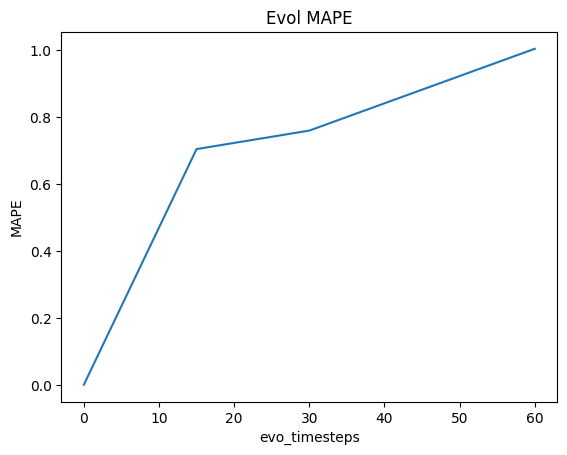

In [40]:
plot.title("Evol MAPE")
plot.plot([0,15,30,60],[0,0.7045167730,0.759789260,1.0043691]) #Per un moment concret es el que tenim
plot.xlabel("evo_timesteps")
plot.ylabel("MAPE")
plot.show()

In [46]:
starting_point=42116
inputs = alll[starting_point+12:]
input_v = alll[starting_point:starting_point+12]

outputs = []
for i in range(len(inputs)):
    res = model_Full.predict(input_v)
    a, input_v=tf.split(input_v,[1,11],0)
    outputs.append(res)
    input_v = tf.concat([input_v,tf.transpose(res)],0)



In [48]:
with open('results_cinquena.csv', 'w', newline='') as file:
    writer = csv.writer(file,delimiter=";")
    writer.writerow(outputs)

In [76]:
outputs = pd.read_csv("results_cinquena.csv",delimiter=";")

In [78]:

extres = outputs
print(extres)

Empty DataFrame
Columns: [[[70.46496 ]
 [65.59107 ]
 [65.71371 ]
 [66.82683 ]
 [70.07104 ]
 [67.58262 ]
 [67.99514 ]
 [67.70893 ]
 [64.00003 ]
 [68.43788 ]
 [65.536964]
 [67.3982  ]
 [68.34716 ]
 [64.748924]
 [67.61669 ]
 [67.967606]
 [68.24239 ]
 [67.099464]
 [68.19189 ]
 [69.29584 ]
 [65.25277 ]
 [60.830883]
 [68.35105 ]
 [66.47863 ]
 [69.31745 ]
 [68.83282 ]
 [67.09997 ]
 [67.92756 ]
 [66.37924 ]
 [67.863945]
 [68.01057 ]
 [65.06494 ]
 [67.36964 ]
 [67.93823 ]
 [67.48369 ]
 [68.44226 ]
 [70.10103 ]
 [66.895325]
 [64.9121  ]
 [68.0044  ]
 [69.00833 ]
 [65.723045]
 [64.79647 ]
 [66.09893 ]
 [67.52061 ]
 [67.956696]
 [67.84456 ]
 [67.75741 ]
 [67.395256]
 [68.40014 ]
 [64.99485 ]
 [69.36784 ]
 [68.470375]
 [65.21436 ]
 [65.529335]
 [68.859116]
 [71.37231 ]
 [72.584274]
 [68.90682 ]
 [68.50202 ]
 [67.509514]
 [68.9431  ]
 [68.01657 ]
 [66.390945]
 [63.874043]
 [67.02661 ]
 [60.880737]
 [65.317024]
 [67.44851 ]
 [66.326454]
 [68.790726]
 [56.08248 ]
 [64.57307 ]
 [66.05709 ]
 [62.517094]

In [75]:
starting_point=42116
pd15 = extres[2]
pd30 = extres[5]
pd60 = extres[11]

og15= alll[starting_point+3]
og30= alll[starting_point+6]
og60= alll[starting_point+12]


IndexError: index 55 is out of bounds for axis 0 with size 1

In [68]:
print(tf.transpose(pd15).shape)
print(np.expand_dims(og15,0).shape)

(1,)
(1, 325)


ValueError: label must be scalar or have the same length as the input data, but found 1 for 325 datasets.

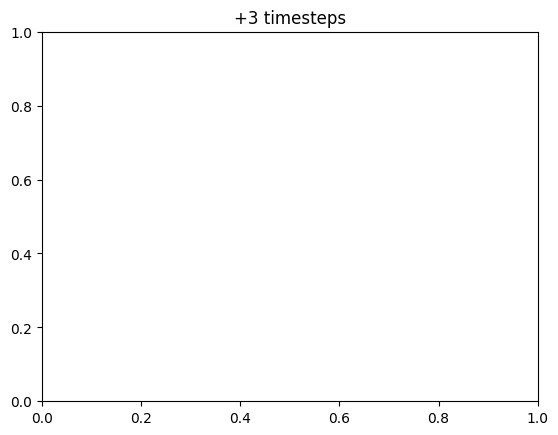

In [112]:
plot.title("+3 timesteps")
plot.plot(tf.transpose(pd15),label=["pred"])
plot.plot(np.expand_dims(og15,0),label=["real"],color = "green") #Per un moment concret es el que tenim
plot.legend()
plot.xlabel("Sensors")
plot.ylabel("Q metric")
plot.show()

In [114]:
mae = tf.keras.losses.MeanAbsoluteError()
mape= tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

ex15 = tf.squeeze(og15)

res_mae = mae(og15,pd15).numpy()
print(res_mae)
res_mape=mape(og15,pd15).numpy()
print(res_mape)
res_mse = mse(og15,pd15).numpy()
print(res_mse)

2.8968616
4.381549
17.471167


In [103]:
mae = tf.keras.losses.MeanAbsoluteError()
mape= tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

ex15 = tf.squeeze(og15)

res_mae = mae(og30,pd30).numpy()
print(res_mae)
res_mape=mape(og30,pd30).numpy()
print(res_mape)
res_mse = mse(og30,pd30).numpy()
print(res_mse)

2.9230664
4.569985
19.417349


In [104]:
mae = tf.keras.losses.MeanAbsoluteError()
mape= tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

ex15 = tf.squeeze(og15)

res_mae = mae(og60,pd60).numpy()
print(res_mae)
res_mape=mape(og60,pd60).numpy()
print(res_mape)
res_mse = mse(og60,pd60).numpy()
print(res_mse)

2.9337165
4.5004325
21.075356


In [54]:
pd10 = outputs[9]
pd50 = outputs[49]
pd100 = outputs[99]
pd500 = outputs[499]
og10= alll[starting_point+10]
og50= alll[starting_point+50]
og100= alll[starting_point+100]
og500= alll[starting_point+500]

In [55]:
mae = tf.keras.losses.MeanAbsoluteError()
mape= tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

res_mae = mae(og10,pd10).numpy()
print(res_mae)
res_mape=mape(og10,pd10).numpy()
print(res_mape)
res_mse = mse(og10,pd10).numpy()
print(res_mse)

3.0039763
4.6503453
21.92653


In [56]:
mae = tf.keras.losses.MeanAbsoluteError()
mape= tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

res_mae = mae(og50,pd50).numpy()
print(res_mae)
res_mape=mape(og50,pd50).numpy()
print(res_mape)
res_mse = mse(og50,pd50).numpy()
print(res_mse)

4.719839
12.42527
64.85296


In [57]:
mae = tf.keras.losses.MeanAbsoluteError()
mape= tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

res_mae = mae(og100,pd100).numpy()
print(res_mae)
res_mape=mape(og100,pd100).numpy()
print(res_mape)
res_mse = mse(og100,pd100).numpy()
print(res_mse)

4.968703
9.385381
63.56009


In [58]:
mae = tf.keras.losses.MeanAbsoluteError()
mape= tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()


res_mae = mae(og500,pd500).numpy()
print(res_mae)
res_mape=mape(og500,pd500).numpy()
print(res_mape)
res_mse = mse(og500,pd500).numpy()
print(res_mse)

2.7704616
4.2047787
20.644497


[68.45011]
68.6
[68.51023]
67.5
[68.51966]
68.8
[68.61066]
69.3
[68.50218]
68.5
[68.805664]
69.7
[68.54788]
69.0
[68.56394]
66.4
[68.546196]
67.4
[68.555664]
68.6
[68.60821]
69.3
[68.57325]
68.9
[68.53597]
68.7
[68.53658]
69.4
[68.53302]
69.9
[68.54171]
68.5
[68.52204]
68.1
[68.54853]
68.0
[68.52285]
66.5
[68.523415]
68.6
[68.52097]
68.0
[68.5185]
68.1
[68.521]
68.0
[68.516594]
68.3
[68.511826]
68.7
[68.51047]
69.5
[68.50837]
68.7
[68.50843]
69.5
[68.5044]
67.7
[68.50582]
68.0
[68.50211]
67.4
[68.501015]
65.8
[68.49973]
67.4
[68.49826]
68.5
[68.497375]
68.3
[68.49598]
68.3
[68.49456]
68.1
[68.49353]
66.9
[68.492386]
67.4
[68.491646]
67.3
[68.490395]
67.9
[68.48984]
67.6
[68.4888]
67.2
[68.488075]
67.4
[68.48739]
67.6
[68.4867]
67.4
[68.48611]
67.1
[68.48551]
67.9
[68.48493]
66.9
[68.48441]
67.7
[68.48388]
66.9
[68.48342]
66.3
[68.482895]
66.5
[68.48246]
66.1
[68.48199]
66.1
[68.481544]
67.6
[68.48113]
67.5
[68.48073]
68.2
[68.480354]
68.0
[68.47999]
67.2
[68.47965]
68.0
[68.479324]
68.

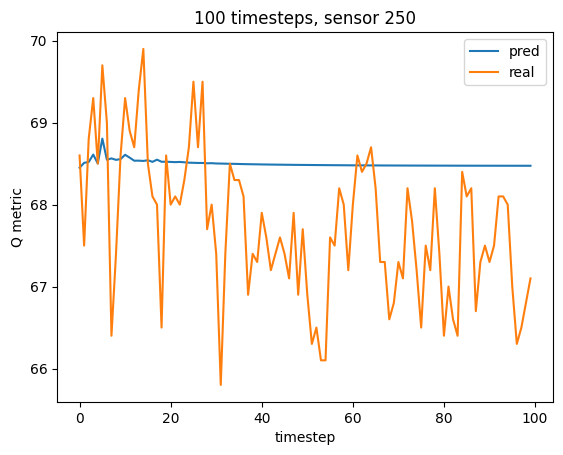

In [53]:
valors_sueltos = []
for x in range(100):
    pred =outputs[x][250]
    print(pred)
    real = alll[starting_point+x][250].numpy()
    print(real)
    valors_sueltos.append([pred,real])

plot.title("100 timesteps, sensor 250")
plot.plot(valors_sueltos,label=["pred","real"]) #Per un moment concret es el que tenim
plot.legend()
plot.xlabel("timestep")
plot.ylabel("Q metric")
plot.show()